In [57]:
import os, re
import pandas as pd
import numpy as np
from Bio import SeqIO

from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import matplotlib.pyplot as plt

from pymmseqs.commands import easy_cluster

# Toxins
(taxonomy_id:33208) AND (cc_tissue_specificity:venom) AND (reviewed:true) AND (keyword:KW-0800) AND (fragment:false)

In [58]:
tox = pd.read_csv('../data/raw/tox.tsv', sep='\t')
tox = tox.dropna(subset=["Protein families"])

mask = tox["Sequence"].str.len() <= 1000
removed = (~mask).sum()

tox = tox[mask].reset_index(drop=True)

tox

,Entry,Sequence,Protein families
0,A0A0B4U9L8,MLQVLLVTICLAVFPYQGSSIILESGNVNDYEVVYPQKLTALLKGA...,"Venom metalloproteinase (M12B) family, P-III s..."
1,A0A0B5A8P4,MTTSFYFLLVALGLLLYVCQSSFGNQHTRNSDTPKHRCGSELADQY...,Insulin family
2,A0A0B5AC95,MTTSSYFLLMALGLLLYVCQSSFGNQHTRTFDTPKHRCGSEITNSY...,Insulin family
3,A0A0D4WV12,GDSRRPIWNIAHMVNDLDLVDEYLDDGANSLELDVEFSKSGTALRT...,"Arthropod phospholipase D family, Class II sub..."
4,A0A0N7CSQ4,MLKSFCILSVFMVLFLAKFPDLCSGEEISPLKIVVRNSEYLNNPCN...,Scoloptoxin-04 family
...,...,...,...
5034,W4VSI7,MKPTISILIFFALAVAIMGHRLNSGYGIPHIVEKLPNGQWCRTPGD...,Neurotoxin 21 family
5035,W4VSI8,MMKLYSLVIIATLAAAAFAATSEEISAAVSEIISQHQEDLERYAKI...,"Neurotoxin 25 family, ICK-8 subfamily"
5036,W4VSI9,MKTLVLVAVLGVASLYLLSSASEVQQLSPAEEEFRAFVSTFGGLFE...,"Neurotoxin 10 (Hwtx-1) family, 27 (ICK-3) subf..."
5037,X5IFY8,MGKLTILVLVAAVLLSTQAMVQGDGDQPAARNAVPRDDNPDGPSAK...,"O2 superfamily, Contryphan family"


In [59]:
tox['Protein families'] = tox['Protein families'].str.split(',').str[0]
tox['Protein families'] = tox['Protein families'].str.split(';').str[0]

In [60]:
tox['Protein families'] = tox['Protein families'].replace('I1 superfamily', 'Conotoxin I1 superfamily')
tox['Protein families'] = tox['Protein families'].replace('O1 superfamily', 'Conotoxin O1 superfamily')
tox['Protein families'] = tox['Protein families'].replace('O2 superfamily', 'Conotoxin O2 superfamily')
tox['Protein families'] = tox['Protein families'].replace('E superfamily', 'Conotoxin E superfamily')
tox['Protein families'] = tox['Protein families'].replace('F superfamily', 'Conotoxin F superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin M family', 'Conotoxin M superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin B2 family', 'Conotoxin B2 superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin O1 family', 'Conotoxin O1 superfamily')
tox['Protein families'] = tox['Protein families'].replace('Conotoxin O2 family', 'Conotoxin O2 superfamily')

In [61]:
mapping = {
    r'Conotoxin.*': 'Conotoxin family',
    r'Neurotoxin.*': 'Neurotoxin family',
    r'Scoloptoxin.*|Scolopendra.*': 'Scoloptoxin family',
    r'Caterpillar.*': 'Caterpillar family',
    r'Teretoxin.*': 'Teretoxin family',
    r'Limacoditoxin.*': 'Limacoditoxin family',
    r'Scutigerotoxin.*': 'Scutigerotoxin family',
    r'Cationic peptide.*': 'Cationic peptide family',
    r'Formicidae venom.*': 'Formicidae venom family',
    r'Bradykinin-potentiating peptide family|Natriuretic peptide family': 'Natriuretic, Bradykinin potentiating peptide family',
    r'.*phospholipase.*|.*Phospholipase.*': 'Phospholipase family'
}

# Apply mapping
for pattern, replacement in mapping.items():
    tox['Protein families'] = tox['Protein families'].str.replace(pattern, replacement, regex=True)

# everything with less than 3 samples is "other"
tox["Protein families"] = tox["Protein families"].where(tox["Protein families"].map(tox["Protein families"].value_counts()) >= 10, "other")

tox['Protein families'].value_counts()

Protein families
Conotoxin family                                       990
Neurotoxin family                                      959
Three-finger toxin family                              485
Long (4 C-C) scorpion toxin superfamily                339
Phospholipase family                                   320
Short scorpion toxin superfamily                       244
other                                                  216
Venom metalloproteinase (M12B) family                  186
Scoloptoxin family                                     155
Peptidase S1 family                                    150
Snaclec family                                         135
Venom Kunitz-type family                               114
Natriuretic, Bradykinin potentiating peptide family     94
Cationic peptide family                                 82
MCD family                                              74
Long (3 C-C) scorpion toxin superfamily                 47
Formicidae venom family                

# Non-Toxins
(taxonomy_id:33208) AND (reviewed:true) AND (fragment:false) NOT (keyword:KW-0800) AND ((existence:1) OR (existence:2))

In [62]:
nontox = pd.read_csv('../data/raw/nontox.tsv', sep='\t')

mask = nontox["Sequence"].str.len() <= 1000
removed = (~mask).sum()

nontox = nontox[mask].reset_index(drop=True)

nontox

,Entry,Sequence,Protein families
0,A0A026W182,MMKMKQQGLVADLLPNIRVMKTFGHFVFNYYNDNSSKYLHKVYCCV...,"Insect chemoreceptor superfamily, Heteromeric ..."
1,A0A044RE18,MYWQLVRILVLFDCLQKILAIEHDSICIADVDDACPEPSHTVMRLR...,"Peptidase S8 family, Furin subfamily"
2,A0A061I403,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...,Fic family
3,A0A075F932,MVSESHHEALAAPPATTVAAAPPSNVTEPASPGGGGGKEDAFSKLK...,Synaptotagmin family
4,A0A088MLT8,MRLEELKRLQNPLEQVDDGKYLLENHQLAMDVENNIENYPLSLQPL...,NaN
...,...,...,...
76461,Q9W3M2,MAKRGKKGGIPRAEMVQVASANRDENQVTELKKADYLPYLFNLVMP...,DM7 family
76462,Q9WVB7,MKPPMQPLTQALPFSLRDALQGTGLRVPVIKMGTGWEGMYRTLKEV...,NaN
76463,Q9XVA4,MPDNHKDPPDFNNLEMKLEERIELSREDQDIQSTSSSYPHCEALDH...,NaN
76464,Q9Y0Y7,MERRYLKNPFPDFAGGENTPFASDEEHIKNLICTYVDAILEHCHPN...,LanC-like protein family


### Fasta Generation

In [63]:
def write_fasta(df, filename):
    """Writes a DataFrame to a FASTA file."""
    with open(filename, "w") as f:
        for _, row in df.iterrows():
            f.write(f">{row['Entry']}\n{row['Sequence']}\n")

write_fasta(tox, "../data/raw/tox.fasta")
write_fasta(nontox, "../data/raw/nontox.fasta")

## Remove SPs
- signalp6 --fastafile data/raw/tox.fasta --output_dir data/sp6/tox/ --organism eukarya --mode fast --model_dir /Users/selin/Desktop/Uni/signalp6/signalp-6-package/models/
- signalp6 --fastafile data/raw/nontox.fasta --output_dir data/sp6/nontox/ --organism eukarya --mode fast --model_dir /Users/selin/Desktop/Uni/signalp6/signalp-6-package/models/

In [64]:
def fasta_to_dataframe(fasta_file):
    records = SeqIO.parse(fasta_file, "fasta")
    data = []

    for record in records:
        id_part = record.id.split('|')[-1]
        data.append({"identifier": id_part, "Sequence": str(record.seq)})

    df = pd.DataFrame(data)
    return df

# SignalP6 all (processed) sequences
proc_tox = fasta_to_dataframe("../data/sp6/tox/processed_entries.fasta")
proc_nontox = fasta_to_dataframe("../data/sp6/nontox/processed_entries.fasta")

In [65]:
proc_tox

,identifier,Sequence
0,A0A0B4U9L8,IILESGNVNDYEVVYPQKLTALLKGAIQQPEQKYEDAMQYEFKVNG...
1,A0A0B5A8P4,NQHTRNSDTPKHRCGSELADQYVQLCHGKRNDAGKKRGRASPLWQR...
2,A0A0B5AC95,NQHTRTFDTPKHRCGSEITNSYMDLCYRKRNDAGEKRGRASPLWQR...
3,A0A0N7CSQ4,EEISPLKIVVRNSEYLNNPCNGVTCPSGYRCSIVDKQCIKKEK
4,A0A193CHJ5,HLLQFNKMIKFETRKNAIPFYAFYGCYCGWGGRGRPKDATDRCCFV...
...,...,...
3450,W4VSI7,HRLNSGYGIPHIVEKLPNGQWCRTPGDDCSESKQCCKPEDTATYAH...
3451,W4VSI8,ATSEEISAAVSEIISQHQEDLERYAKIVERGEEPKKYIRCSKQLGQ...
3452,W4VSI9,SEVQQLSPAEEEFRAFVSTFGGLFETEERGVDSEDCRAMFGGCGED...
3453,X5IFY8,DGDQPAARNAVPRDDNPDGPSAKFMNVQRRSGCPWEPWCG


In [66]:
gff3_tox = pd.read_csv('../data/sp6/tox/output.gff3', sep='\t', comment='#', header=None)
gff3_nontox = pd.read_csv('../data/sp6/nontox/output.gff3', sep='\t', comment='#', header=None)

cols = [
    'identifier', 'source', 'feature_type', 'start', 'end',
    'score', 'strand', 'phase', 'attributes'
]
gff3_tox.columns = cols
gff3_nontox.columns = cols

def extract_seqid(full_seqid):
    return full_seqid.split('|')[-1].split(' ')[0]

gff3_tox['identifier'] = gff3_tox['identifier'].apply(extract_seqid)
gff3_nontox['identifier'] = gff3_nontox['identifier'].apply(extract_seqid)

gff3_tox = pd.merge(gff3_tox, proc_tox, on='identifier')
gff3_nontox = pd.merge(gff3_nontox, proc_nontox, on='identifier')

In [67]:
gff3_tox[gff3_tox['score'] > 0.8]

,identifier,source,feature_type,start,end,score,strand,phase,attributes,Sequence
0,A0A0B4U9L8,SignalP-6.0,signal_peptide,1,20,0.999781,.,.,.,IILESGNVNDYEVVYPQKLTALLKGAIQQPEQKYEDAMQYEFKVNG...
1,A0A0B5A8P4,SignalP-6.0,signal_peptide,1,24,0.999788,.,.,.,NQHTRNSDTPKHRCGSELADQYVQLCHGKRNDAGKKRGRASPLWQR...
2,A0A0B5AC95,SignalP-6.0,signal_peptide,1,24,0.999788,.,.,.,NQHTRTFDTPKHRCGSEITNSYMDLCYRKRNDAGEKRGRASPLWQR...
3,A0A0N7CSQ4,SignalP-6.0,signal_peptide,1,25,0.999729,.,.,.,EEISPLKIVVRNSEYLNNPCNGVTCPSGYRCSIVDKQCIKKEK
4,A0A193CHJ5,SignalP-6.0,signal_peptide,1,16,0.998810,.,.,.,HLLQFNKMIKFETRKNAIPFYAFYGCYCGWGGRGRPKDATDRCCFV...
...,...,...,...,...,...,...,...,...,...,...
3450,W4VSI7,SignalP-6.0,signal_peptide,1,19,0.999751,.,.,.,HRLNSGYGIPHIVEKLPNGQWCRTPGDDCSESKQCCKPEDTATYAH...
3451,W4VSI8,SignalP-6.0,signal_peptide,1,19,0.999768,.,.,.,ATSEEISAAVSEIISQHQEDLERYAKIVERGEEPKKYIRCSKQLGQ...
3452,W4VSI9,SignalP-6.0,signal_peptide,1,21,0.999693,.,.,.,SEVQQLSPAEEEFRAFVSTFGGLFETEERGVDSEDCRAMFGGCGED...
3453,X5IFY8,SignalP-6.0,signal_peptide,1,23,0.999690,.,.,.,DGDQPAARNAVPRDDNPDGPSAKFMNVQRRSGCPWEPWCG


### merge with SP6 predictions

In [68]:
# 1) Build filtered DataFrames with a “new” Sequence column
filtered_tox = (
    gff3_tox[gff3_tox['score'] > 0.8]
    [['identifier', 'Sequence']]
    .rename(columns={'identifier': 'Entry',
                     'Sequence':   'Sequence_new'})
)

filtered_nontox = (
    gff3_nontox[gff3_nontox['score'] > 0.8]
    [['identifier', 'Sequence']]
    .rename(columns={'identifier': 'Entry',
                     'Sequence':   'Sequence_new'})
)

# 2) Merge into your existing tables, keeping all original rows
tox = tox.merge(filtered_tox, on='Entry', how='left')
nontox = nontox.merge(filtered_nontox, on='Entry', how='left')

# 3) Wherever we have a Sequence_new, use it; otherwise keep the old Sequence
tox['Sequence']    = tox['Sequence_new'].fillna(tox['Sequence'])
nontox['Sequence'] = nontox['Sequence_new'].fillna(nontox['Sequence'])

# 4) Drop the temporary column
tox.drop(columns='Sequence_new',    inplace=True)
nontox.drop(columns='Sequence_new', inplace=True)

In [69]:
tox

,Entry,Sequence,Protein families
0,A0A0B4U9L8,IILESGNVNDYEVVYPQKLTALLKGAIQQPEQKYEDAMQYEFKVNG...,Venom metalloproteinase (M12B) family
1,A0A0B5A8P4,NQHTRNSDTPKHRCGSELADQYVQLCHGKRNDAGKKRGRASPLWQR...,Insulin family
2,A0A0B5AC95,NQHTRTFDTPKHRCGSEITNSYMDLCYRKRNDAGEKRGRASPLWQR...,Insulin family
3,A0A0D4WV12,GDSRRPIWNIAHMVNDLDLVDEYLDDGANSLELDVEFSKSGTALRT...,Phospholipase family
4,A0A0N7CSQ4,EEISPLKIVVRNSEYLNNPCNGVTCPSGYRCSIVDKQCIKKEK,Scoloptoxin family
...,...,...,...
5034,W4VSI7,HRLNSGYGIPHIVEKLPNGQWCRTPGDDCSESKQCCKPEDTATYAH...,Neurotoxin family
5035,W4VSI8,ATSEEISAAVSEIISQHQEDLERYAKIVERGEEPKKYIRCSKQLGQ...,Neurotoxin family
5036,W4VSI9,SEVQQLSPAEEEFRAFVSTFGGLFETEERGVDSEDCRAMFGGCGED...,Neurotoxin family
5037,X5IFY8,DGDQPAARNAVPRDDNPDGPSAKFMNVQRRSGCPWEPWCG,Conotoxin family


In [70]:
nontox["Protein families"] = "nontox"
nontox

,Entry,Sequence,Protein families
0,A0A026W182,MMKMKQQGLVADLLPNIRVMKTFGHFVFNYYNDNSSKYLHKVYCCV...,nontox
1,A0A044RE18,IEHDSICIADVDDACPEPSHTVMRLRERNDKKAHLIAKQHGLEIRG...,nontox
2,A0A061I403,MPMASVIAVAEPKWISVWGRFLWLTLLSMALGSLLALLLPLGAVEE...,nontox
3,A0A075F932,MVSESHHEALAAPPATTVAAAPPSNVTEPASPGGGGGKEDAFSKLK...,nontox
4,A0A088MLT8,MRLEELKRLQNPLEQVDDGKYLLENHQLAMDVENNIENYPLSLQPL...,nontox
...,...,...,...
76461,Q9W3M2,MAKRGKKGGIPRAEMVQVASANRDENQVTELKKADYLPYLFNLVMP...,nontox
76462,Q9WVB7,MKPPMQPLTQALPFSLRDALQGTGLRVPVIKMGTGWEGMYRTLKEV...,nontox
76463,Q9XVA4,MPDNHKDPPDFNNLEMKLEERIELSREDQDIQSTSSSYPHCEALDH...,nontox
76464,Q9Y0Y7,MERRYLKNPFPDFAGGENTPFASDEEHIKNLICTYVDAILEHCHPN...,nontox


### merge dataframes

In [71]:
data = pd.concat([tox, nontox], ignore_index=True)
data

,Entry,Sequence,Protein families
0,A0A0B4U9L8,IILESGNVNDYEVVYPQKLTALLKGAIQQPEQKYEDAMQYEFKVNG...,Venom metalloproteinase (M12B) family
1,A0A0B5A8P4,NQHTRNSDTPKHRCGSELADQYVQLCHGKRNDAGKKRGRASPLWQR...,Insulin family
2,A0A0B5AC95,NQHTRTFDTPKHRCGSEITNSYMDLCYRKRNDAGEKRGRASPLWQR...,Insulin family
3,A0A0D4WV12,GDSRRPIWNIAHMVNDLDLVDEYLDDGANSLELDVEFSKSGTALRT...,Phospholipase family
4,A0A0N7CSQ4,EEISPLKIVVRNSEYLNNPCNGVTCPSGYRCSIVDKQCIKKEK,Scoloptoxin family
...,...,...,...
81500,Q9W3M2,MAKRGKKGGIPRAEMVQVASANRDENQVTELKKADYLPYLFNLVMP...,nontox
81501,Q9WVB7,MKPPMQPLTQALPFSLRDALQGTGLRVPVIKMGTGWEGMYRTLKEV...,nontox
81502,Q9XVA4,MPDNHKDPPDFNNLEMKLEERIELSREDQDIQSTSSSYPHCEALDH...,nontox
81503,Q9Y0Y7,MERRYLKNPFPDFAGGENTPFASDEEHIKNLICTYVDAILEHCHPN...,nontox


In [72]:
write_fasta(tox, "../data/interm/tox_noSP.fasta")
write_fasta(nontox, "../data/interm/nontox_noSP.fasta")

## Clustering
### run mmseqs2 90% sequence similarity clustering per protein family

In [73]:
out_dir = "../data/families/"
os.makedirs(out_dir, exist_ok=True)

def sanitize_filename(name):
    sanitized = re.sub(r"[^a-zA-Z0-9_-]", "_", name)
    return sanitized

failed = []

# run for all data (tox and nontox)
for family, group in data.groupby("Protein families"):
    safe_family = sanitize_filename(family)

    fasta_path = os.path.join(out_dir, f"{safe_family}.fasta")
    write_fasta(group, fasta_path)

    # Create family-specific mmseqs directory
    family_mmseqs_dir = os.path.join("../data/mmseqs", safe_family)
    os.makedirs(family_mmseqs_dir, exist_ok=True)

    cluster_prefix = os.path.join(family_mmseqs_dir, "cluster")
    tmp_dir = os.path.join(family_mmseqs_dir, "tmp")
    os.makedirs(tmp_dir, exist_ok=True)

    try:
        easy_cluster(
            fasta_files=fasta_path,
            cluster_prefix=cluster_prefix,
            tmp_dir=tmp_dir,
            min_seq_id=0.9
        )
    except Exception as e:
        print(f"⚠️ Skipping {safe_family} due to error: {e}")
        failed.append((fasta_path, cluster_prefix, tmp_dir))

# Print mmseqs commands for failures
if failed:
    print("\n🔁 Manual mmseqs2 commands for failed entries:\n")
    for fasta, out, tmp in failed:
        print(f"mmseqs easy-cluster {fasta} {out} {tmp} --min-seq-id 0.9")


-------------------- Running a mmseqs2 command --------------------
✓ Detailed execution log has been saved
✓ Easy Cluster completed successfully
  Results saved to: /Users/selin/PycharmProjects/ToxFam/data/mmseqs/AVIT__prokineticin__family/cluster

-------------------- Running a mmseqs2 command --------------------
✓ Detailed execution log has been saved
✓ Easy Cluster completed successfully
  Results saved to: /Users/selin/PycharmProjects/ToxFam/data/mmseqs/Bradykinin-related_peptide_family/cluster

-------------------- Running a mmseqs2 command --------------------
✓ Detailed execution log has been saved
✓ Easy Cluster completed successfully
  Results saved to: /Users/selin/PycharmProjects/ToxFam/data/mmseqs/CRISP_family/cluster

-------------------- Running a mmseqs2 command --------------------
✓ Detailed execution log has been saved
✓ Easy Cluster completed successfully
  Results saved to: /Users/selin/PycharmProjects/ToxFam/data/mmseqs/Cationic_peptide_family/cluster

---------

In [74]:
mmseqs_base_dir = "../data/mmseqs"
# containers
rep_seqs_tox = []
rep_seqs_all = []

# iterate all family subdirs
for family_dir in os.listdir(mmseqs_base_dir):
    full_path = os.path.join(mmseqs_base_dir, family_dir)
    if not os.path.isdir(full_path):
        print(f"skipping {full_path}")
        continue

    rep_fasta = os.path.join(full_path, "cluster_rep_seq.fasta")
    if not os.path.exists(rep_fasta):
        continue

    # collect all seqs in this family
    this_family_seqs = [
        {"Entry": rec.id, "Sequence": str(rec.seq)}
        for rec in SeqIO.parse(rep_fasta, "fasta")
    ]
    # always add to “all”
    rep_seqs_all.extend(this_family_seqs)

    # only add to “tox” if not the nontox folder
    if family_dir != "nontox":
        rep_seqs_tox.extend(this_family_seqs)

# make DataFrames and merge on Protein families
rep_df_all = (
    pd.DataFrame(rep_seqs_all)
      .merge(data[["Entry","Protein families"]], on="Entry", how="left")
)

rep_df_tox = (
    pd.DataFrame(rep_seqs_tox)
      .merge(data[["Entry","Protein families"]], on="Entry", how="left")
)

rep_df_tox["Protein families"].value_counts()

skipping ../data/mmseqs/.DS_Store


Protein families
Conotoxin family                                       754
Neurotoxin family                                      400
Three-finger toxin family                              240
Long (4 C-C) scorpion toxin superfamily                188
other                                                  172
Phospholipase family                                   171
Short scorpion toxin superfamily                       170
Venom metalloproteinase (M12B) family                  123
Scoloptoxin family                                     121
Snaclec family                                          92
Peptidase S1 family                                     87
Natriuretic, Bradykinin potentiating peptide family     69
MCD family                                              61
Venom Kunitz-type family                                48
Cationic peptide family                                 48
Formicidae venom family                                 35
Long (3 C-C) scorpion toxin superfamily

In [75]:
rep_df_all["Protein families"] = rep_df_all["Protein families"].where(rep_df_all["Protein families"].map(rep_df_all["Protein families"].value_counts()) >= 10, "other")
rep_df_tox["Protein families"] = rep_df_tox["Protein families"].where(rep_df_tox["Protein families"].map(rep_df_tox["Protein families"].value_counts()) >= 10, "other")

rep_df_tox["Protein families"].value_counts()

Protein families
Conotoxin family                                       754
Neurotoxin family                                      400
Three-finger toxin family                              240
other                                                  209
Long (4 C-C) scorpion toxin superfamily                188
Phospholipase family                                   171
Short scorpion toxin superfamily                       170
Venom metalloproteinase (M12B) family                  123
Scoloptoxin family                                     121
Snaclec family                                          92
Peptidase S1 family                                     87
Natriuretic, Bradykinin potentiating peptide family     69
MCD family                                              61
Cationic peptide family                                 48
Venom Kunitz-type family                                48
Formicidae venom family                                 35
Long (3 C-C) scorpion toxin superfamily

In [76]:
rep_df_tox.rename(
    columns={"Entry": "identifier"}
)[["identifier", "Protein families"]].to_csv(
    "../data/protspace/tox.csv",
    index=False
)
rep_df_all.rename(
    columns={"Entry": "identifier"}
)[["identifier", "Protein families"]].to_csv(
    "../data/protspace/all.csv",
    index=False
)

rep_df_tox

,Entry,Sequence,Protein families
0,P01501,APEPEPAPEPEAEADAEADPEAGIGAVLKVLTTGLPALISWIKRKRQQG,other
1,Q8LW54,MKFLVNVALVFYGRVHFLHLCVHFLHLWAPEPEPAPEAEAEADAEA...,other
2,P01502,GIGAILKVLSTGLPALISWIKRKRQE,other
3,P01504,GIGAILKVLATGLPTLISWIKNKRKQ,other
4,P84805,NVDFNSESTRRKKKQKEIVDLHNSLRRRVSPTASNMLKMEWYPEAA...,CRISP family
...,...,...,...
3041,Q9BLM2,VRDGYFVEPDNCVIYCMPSSEVCDRGCKHNGATSGTCKEFSKGGNV...,Long (3 C-C) scorpion toxin superfamily
3042,Q66S03,ANVTRRATSSCPKGWTHHGSRCFTFHRGSMDWASAEAACIRKGGNL...,other
3043,A7X3W6,DNCPASWISRNGVCNKLFPDRKTWLEAEKRTWKWSDRTSTNYFSWN...,other
3044,A7X3X0,DNCPASWISRNGVCNKLFPDRKTWLEAEMYCRALKPGCHLASLHRD...,other


In [77]:
rep_df_all

,Entry,Sequence,Protein families
0,P01501,APEPEPAPEPEAEADAEADPEAGIGAVLKVLTTGLPALISWIKRKRQQG,other
1,Q8LW54,MKFLVNVALVFYGRVHFLHLCVHFLHLWAPEPEPAPEAEAEADAEA...,other
2,P01502,GIGAILKVLSTGLPALISWIKRKRQE,other
3,P01504,GIGAILKVLATGLPTLISWIKNKRKQ,other
4,P84805,NVDFNSESTRRKKKQKEIVDLHNSLRRRVSPTASNMLKMEWYPEAA...,CRISP family
...,...,...,...
52092,Q9BLM2,VRDGYFVEPDNCVIYCMPSSEVCDRGCKHNGATSGTCKEFSKGGNV...,Long (3 C-C) scorpion toxin superfamily
52093,Q66S03,ANVTRRATSSCPKGWTHHGSRCFTFHRGSMDWASAEAACIRKGGNL...,other
52094,A7X3W6,DNCPASWISRNGVCNKLFPDRKTWLEAEKRTWKWSDRTSTNYFSWN...,other
52095,A7X3X0,DNCPASWISRNGVCNKLFPDRKTWLEAEMYCRALKPGCHLASLHRD...,other


In [78]:
# Fastas for embedding generation
write_fasta(rep_df_tox, "../data/protspace/tox.fasta")
write_fasta(rep_df_all, "../data/protspace/all.fasta")

### Train-Val-Test sets with 70:15:15 split

In [79]:
# Copy the full dataframe to avoid modifying the original
df = rep_df_all.copy()

# Convert the 'Protein families' column to a list of family labels for each sample
# If the entry is a string, split on commas; otherwise, assign an empty list
df['fam_list'] = df['Protein families'].apply(
    lambda x: x.split(',') if isinstance(x, str) else []
)

# Create a binary indicator matrix for multilabel stratification
mlb = MultiLabelBinarizer()
# Y is a 2D array: rows correspond to samples, columns to family labels
Y = mlb.fit_transform(df['fam_list'])

# 1) Hold out 15% of the data as the final test set
# Use a stratified shuffle split to preserve label distribution across sets
msss1 = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.15,
    random_state=42
)
trainval_idx, test_idx = next(msss1.split(df, Y))
# Create train+validation and test dataframes
df_trainval = df.iloc[trainval_idx].reset_index(drop=True)
test_df     = df.iloc[test_idx].reset_index(drop=True)
# Keep corresponding label matrix for the train+validation set
Y_trainval  = Y[trainval_idx]

# 2) Split the remaining data into training (~70% of total) and validation (~15% of total)
# Calculate the validation fraction relative to the remaining 85%
val_frac = 0.15 / 0.85  # ≈ 0.176
msss2 = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=val_frac,
    random_state=42
)
train_idx, val_idx = next(msss2.split(df_trainval, Y_trainval))
# Create separate training and validation dataframes
train_df = df_trainval.iloc[train_idx].reset_index(drop=True)
val_df   = df_trainval.iloc[val_idx].reset_index(drop=True)

# 3) (Optional) Convert the list of families back to comma-separated strings
for subset in (train_df, val_df, test_df):
    subset['Protein families'] = subset['fam_list'].apply(','.join)

# Remove the temporary 'fam_list' column from all subsets
for subset in (train_df, val_df, test_df):
    subset.drop(columns='fam_list', inplace=True)

# Print dataset sizes and their percentages of the original data
total = len(rep_df_all)
print(f"Train size: {len(train_df)} ({len(train_df)/total*100:.2f}%)")
print(f"Validation size: {len(val_df)} ({len(val_df)/total*100:.2f}%)")
print(f"Test size: {len(test_df)} ({len(test_df)/total*100:.2f}%)")

Train size: 36469 (70.00%)
Validation size: 7813 (15.00%)
Test size: 7815 (15.00%)


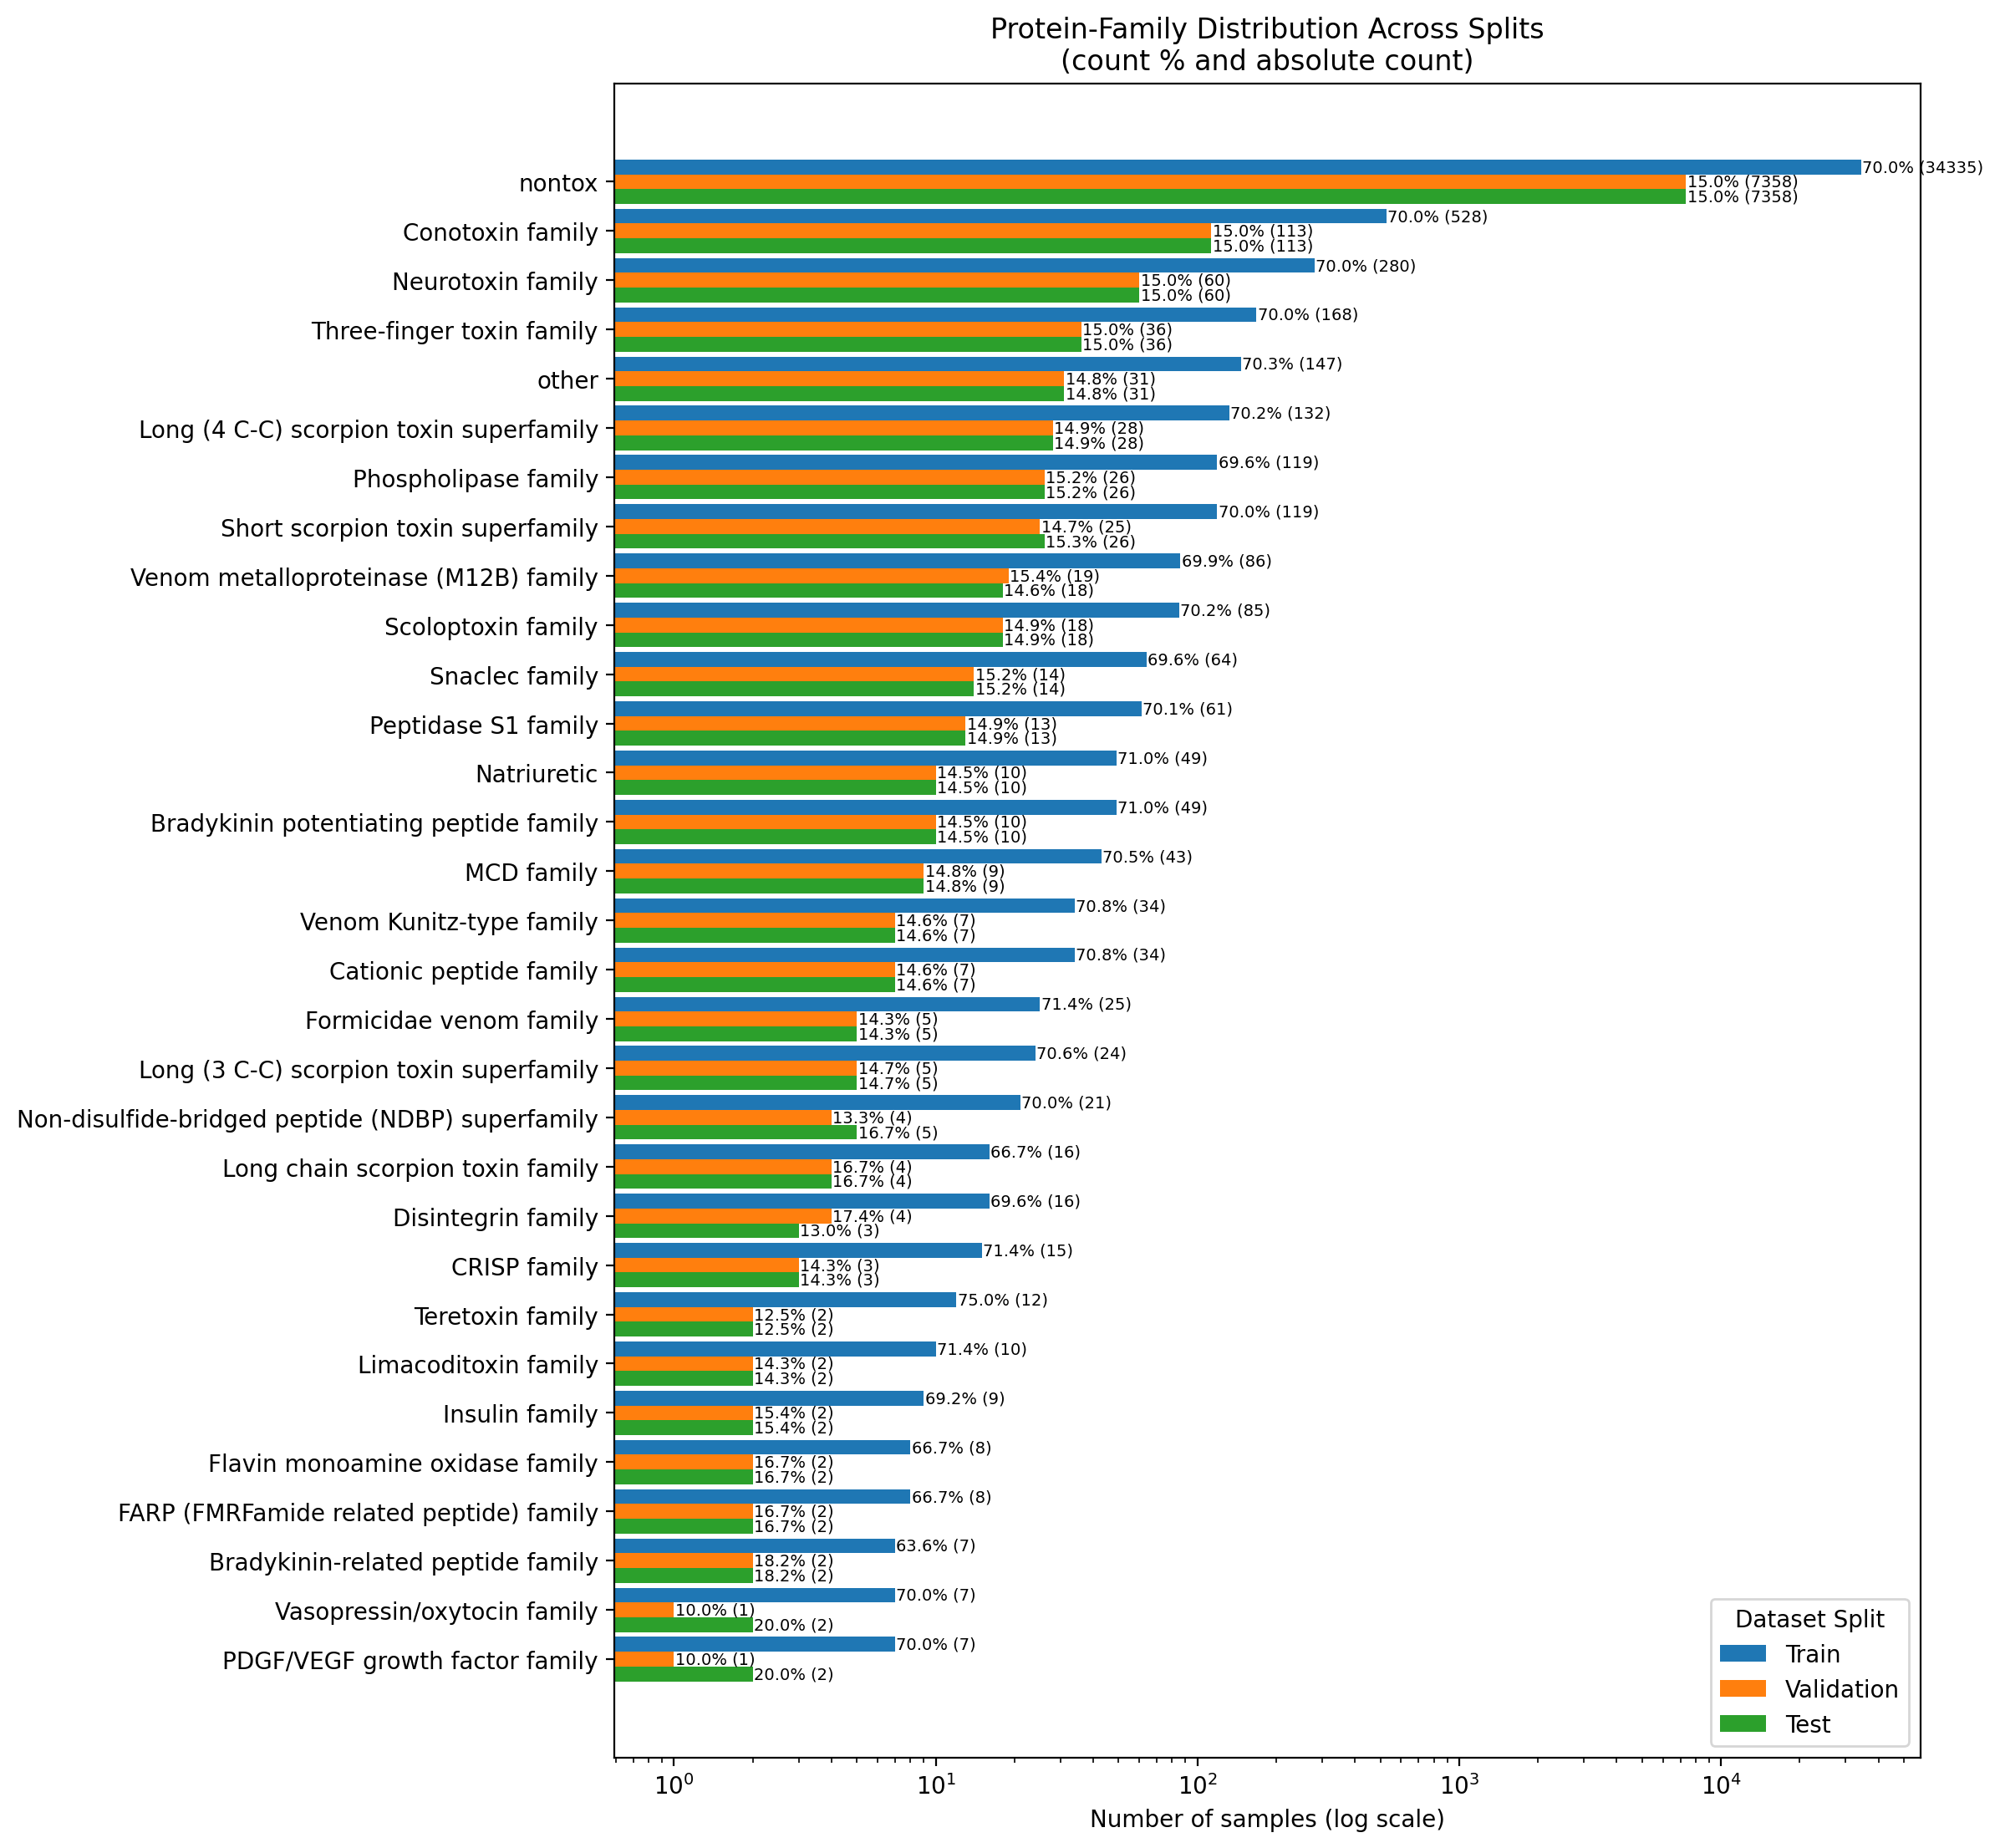

In [80]:
def plot_family_counts_and_pcts_hbar_log(train_df, val_df, test_df, bar_height=0.3):
    # 1) compute absolute counts
    def explode_counts(df):
        return df['Protein families'].str.split(',').explode().value_counts()
    train_ct = explode_counts(train_df)
    val_ct   = explode_counts(val_df)
    test_ct  = explode_counts(test_df)

    # 2) unify into one DataFrame
    all_fam = sorted(set(train_ct.index) | set(val_ct.index) | set(test_ct.index))
    counts = pd.DataFrame({
        'Train': train_ct,
        'Validation': val_ct,
        'Test': test_ct
    }).reindex(all_fam, fill_value=0).astype(int)

    # 3) sort by total count ascending so largest at bottom
    counts['Total'] = counts.sum(axis=1)
    counts = counts.sort_values('Total', ascending=True).drop(columns='Total')
    families = counts.index.tolist()

    # 4) compute row‐percentages
    pcts = counts.div(counts.sum(axis=1), axis=0) * 100

    # 5) plotting
    fig, ax = plt.subplots(figsize=(12, max(6, len(families)*bar_height*1.2)), dpi=200)
    y = np.arange(len(families))
    splits = ['Train', 'Validation', 'Test']
    offsets = [bar_height, 0, -bar_height]

    for off, split in zip(offsets, splits):
        bars = ax.barh(y + off, counts[split], bar_height, label=split)
        for bar, ct, pct in zip(bars, counts[split], pcts[split]):
            if ct > 0:
                # place label just outside the bar, centered vertically
                x = bar.get_width() * 1.01
                y_text = bar.get_y() + bar.get_height() / 2
                ax.text(
                    x, y_text,
                    f"{pct:.1f}% ({ct})",
                    va='center', ha='left', fontsize=7
                )

    ax.set_xscale('log')
    ax.set_yticks(y)
    ax.set_yticklabels(families)
    ax.set_xlabel("Number of samples (log scale)")
    ax.set_title("Protein-Family Distribution Across Splits\n(count % and absolute count)")
    ax.legend(title="Dataset Split", loc='lower right')
    plt.tight_layout()
    plt.show()

# Usage:
plot_family_counts_and_pcts_hbar_log(train_df, val_df, test_df)

## generate final training data

In [81]:
# Add 'Split' column to each dataframe
train_df['Split'] = 'train'
val_df['Split'] = 'val'
test_df['Split'] = 'test'

# Concatenate all dataframes
training_data = pd.concat([train_df, val_df, test_df], ignore_index=True)

training_data

,Entry,Sequence,Protein families,Split
0,P01501,APEPEPAPEPEAEADAEADPEAGIGAVLKVLTTGLPALISWIKRKRQQG,other,train
1,Q8LW54,MKFLVNVALVFYGRVHFLHLCVHFLHLWAPEPEPAPEAEAEADAEA...,other,train
2,P01504,GIGAILKVLATGLPTLISWIKNKRKQ,other,train
3,P84805,NVDFNSESTRRKKKQKEIVDLHNSLRRRVSPTASNMLKMEWYPEAA...,CRISP family,train
4,Q7ZT99,SVDFDSESPRKPEIQNKIVDLHNFLRRSVNPTASNMLKMEWYPEAA...,CRISP family,train
...,...,...,...,...
52092,B8XH01,SDPPGNYPLNTYGNKYACTILGENDFCQKICKVHGVQYGYCFNSRC...,Long (3 C-C) scorpion toxin superfamily,test
52093,A0A7S8MVF3,VRDGYPILKNGCSCTCQPLLENPKCGAICKSKVGISKAYCYMWACR...,Long (3 C-C) scorpion toxin superfamily,test
52094,Q9BLM1,VRDGYFVEPDNCLVYCMPSPEICDRGCKRYGATSGFCKEFSKGENF...,Long (3 C-C) scorpion toxin superfamily,test
52095,Q9BLM2,VRDGYFVEPDNCVIYCMPSSEVCDRGCKHNGATSGTCKEFSKGGNV...,Long (3 C-C) scorpion toxin superfamily,test


In [82]:
len(training_data["Protein families"].unique())

30

In [83]:
training_data.to_csv("../data/interm/training_data.csv", index=False)

generate per-protein embeddings on LRZ server using training_data.fasta